# PySpark Demo - Clustering at scale

Kim Hee (Graduate research assistant) <br>
Universitätsmedizin Mannheim, Mannheim (UMM)

* This is prepared for `Data analysis tools (Datenanalysewerkzeuge)` at MIRACUM summer school 2019

### Three type of data analytics
<img src = "images/three_analytics.jpg" style="float:left; padding-right:30px;"/>

* Descriptive analytics lets businesses see what has already happened.
* Predictive analytics helps businesses see what could happen in the future.
* Prescriptive analytics recommend you what to do.  
(image source: https://t.ly/rBOR9)


### Protocol:
<b>1. Create a Spark Context</b><br>
</b>2. Import required libraries</b><br>
</b>3. Load the [data](https://data.cityofnewyork.us/Transportation/2018-Yellow-Taxi-Trip-Data/t29m-gskq)</b><br>
</b>4. Create a KMeans model</b><br>
</b>5. Assign centroids to the data</b><br>
</b>6. Visualize the result</b><br>
</b>7. Aggregate the result and visualize it</b><br>

In [1]:
from pyspark import SparkContext
sc = SparkContext()
sc

<SparkContext master=local[*] appName=pyspark-shell>

### Protocol:
</b>1. Create a Spark Context</b><br>
<b>2. Import required libraries</b><br>
</b>3. Load the [data](https://data.cityofnewyork.us/Transportation/2018-Yellow-Taxi-Trip-Data/t29m-gskq)</b><br>
</b>4. Create a KMeans model</b><br>
</b>5. Assign centroids to the data</b><br>
</b>6. Visualize the result</b><br>
</b>7. Aggregate the result and visualize it</b><br>

In [17]:
from pyspark.mllib.clustering import KMeans, KMeansModel
import numpy as np
import pandas as pd
from dateutil import parser
import folium
from folium import plugins
import matplotlib.pyplot as plt
%matplotlib inline

### Protocol:
</b>1. Create a Spark Context</b><br>
</b>2. Import required libraries</b><br>
<b>3. Load and prepare the [data](https://data.cityofnewyork.us/Transportation/2018-Yellow-Taxi-Trip-Data/t29m-gskq)</b><br>
</b>4. Create a KMeans model</b><br>
</b>5. Assign centroids to the data</b><br>
</b>6. Visualize the result</b><br>
</b>7. Aggregate the result and visualize it</b><br>

In [3]:
raw = sc.textFile("data/uber_1k.csv")
raw.take(2)

[',2014-08-01 00:00:00,40.729,-73.9422,B02598',
 '0,2014-08-01 00:00:00,40.7476,-73.9871,B02598']

In [4]:
line = raw.map(lambda x: x.split(','))
line.take(2)

[['', '2014-08-01 00:00:00', '40.729', '-73.9422', 'B02598'],
 ['0', '2014-08-01 00:00:00', '40.7476', '-73.9871', 'B02598']]

In [5]:
geo = line.map(lambda x: (float(x[2]), float(x[3])))
geo.take(2)

[(40.729, -73.9422), (40.7476, -73.9871)]

### Protocol:
</b>1. Create a Spark Context</b><br>
</b>2. Import required libraries</b><br>
</b>3. Load the [data](https://data.cityofnewyork.us/Transportation/2018-Yellow-Taxi-Trip-Data/t29m-gskq)</b><br>
<b>4. Create a KMeans model</b><br>
</b>5. Assign centroids to the data</b><br>
</b>6. Visualize the result</b><br>
</b>7. Aggregate the result and visualize it</b><br>

In [8]:
k = 8
model = KMeans.train(geo, k)

### Protocol:
</b>1. Create a Spark Context</b><br>
</b>2. Import required libraries</b><br>
</b>3. Load the [data](https://data.cityofnewyork.us/Transportation/2018-Yellow-Taxi-Trip-Data/t29m-gskq)</b><br>
</b>4. Create a KMeans model</b><br>
<b>5. Assign centroids to the data</b><br>
</b>6. Visualize the result</b><br>
</b>7. Aggregate the result and visualize it</b><br>

In [16]:
clusters = model.predict(geo)
clusters.take(20)

[2, 1, 1, 1, 1, 2, 2, 2, 1, 6, 2, 6, 2, 6, 1, 1, 1, 1, 1, 1]

### Protocol:
</b>1. Create a Spark Context</b><br>
</b>2. Import required libraries</b><br>
</b>3. Load the [data](https://data.cityofnewyork.us/Transportation/2018-Yellow-Taxi-Trip-Data/t29m-gskq)</b><br>
</b>4. Create a KMeans model</b><br>
</b>5. Assign centroids to the data</b><br>
<b>6. Visualize the result</b><br>
</b>7. Aggregate the result and visualize it</b><br>

In [23]:
# data preparation
dt = line.map(lambda x: parser.parse(x[1])).collect()
lat = geo.map(lambda x: float(x[0])).collect()
lon = geo.map(lambda x: float(x[1])).collect()
clusters = clusters.collect()

df_list = list(map(lambda w,x,y,z:[w,x,y,z], lat, lon, dt, clusters))
df_list[:2]

[[40.729, -73.9422, datetime.datetime(2014, 8, 1, 0, 0), 2],
 [40.7476, -73.9871, datetime.datetime(2014, 8, 1, 0, 0), 1]]

In [18]:
# a look up function for coloring
def my_palettes(cluster):
    if cluster ==  0:
        return 'green'
    elif cluster ==  1:
        return 'yellow'
    elif cluster ==  2:
        return 'red'
    elif cluster ==  3:
        return 'blue'
    elif cluster ==  4:
        return 'orange'
    elif cluster ==  5:
        return 'skyblue'
    elif cluster ==  6:
        return 'gray'
    elif cluster ==  7:
        return 'purple'
    else:
        return 'black'

In [26]:
# create a map object of new york
NY_COORDINATES = (40.729, -73.9422)
map_ny = folium.Map(location = NY_COORDINATES, width = "100%", zoom_start = 12) # max zoom: 18
folium.TileLayer('cartodbpositron').add_to(map_ny) # stamentoner
map_ny

In [27]:
# add a layer of the clustering result
for i in range(0, len(df_list)):
    folium.RegularPolygonMarker(location = df_list[i][:2], \
                                stroke = False, \
                                fill_color = my_palettes(df_list[i][3]), \
                                fill_opacity = 0.5, number_of_sides = 12,  radius = 3
                               ).add_to(map_ny) 
map_ny

### Protocol:
</b>1. Create a Spark Context</b><br>
</b>2. Import required libraries</b><br>
</b>3. Load the [data](https://data.cityofnewyork.us/Transportation/2018-Yellow-Taxi-Trip-Data/t29m-gskq)</b><br>
</b>4. Create a KMeans model</b><br>
</b>5. Assign centroids to the data</b><br>
</b>6. Visualize the result</b><br>
<b>7. Aggregate the result and visualize it</b><br>

In [60]:
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName('test').getOrCreate()
# raw = spark.read.csv("data/uber.csv", inferSchema = True, header = True)
# raw.take(2)

In [134]:
# import pyspark.sql 
# rdd = line.map(lambda x: ( parser.parse(x[1]), float(x[2]), float(x[3]) ))
# df = sqlContext.createDataFrame(rdd, ["dt","lat","lon"])
# df.head(5)

In [66]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import countDistinct, avg, stddev

sqlContext = SQLContext(sc)
sqlContext

In [61]:
raw = sc.textFile("data/uber.csv")
line = raw.map(lambda x: x.split(','))
geo = line.map(lambda x: (float(x[1]), float(x[2])))
rdd = line.map(lambda x: ( parser.parse(x[0]), float(x[1]), float(x[2]) ))
dt = line.map(lambda x:  x[0])

In [62]:
results = model.predict(geo).zip(dt)
temp = sqlContext.createDataFrame(results, ["cluster", "dt"])
temp.show(5)

+-------+-------------------+
|cluster|                 dt|
+-------+-------------------+
|      2|2014-08-01 00:00:00|
|      1|2014-08-01 00:00:00|
|      1|2014-08-01 00:00:00|
|      1|2014-08-01 00:00:00|
|      1|2014-08-01 00:00:00|
+-------+-------------------+
only showing top 5 rows



In [69]:
sqlContext.registerDataFrameAsTable(temp, "temp")
temp = sqlContext.sql("SELECT cluster, substring(dt, 0,4) AS year, substring(dt, 6,2) AS month, substring(dt, 9,2) AS date, substring(dt, 12,2) AS hr FROM temp")
sqlContext.registerDataFrameAsTable(temp, "temp")
temp.show(5)

+-------+----+-----+----+---+
|cluster|year|month|date| hr|
+-------+----+-----+----+---+
|      2|2014|   08|  01| 00|
|      1|2014|   08|  01| 00|
|      1|2014|   08|  01| 00|
|      1|2014|   08|  01| 00|
|      1|2014|   08|  01| 00|
+-------+----+-----+----+---+
only showing top 5 rows



In [74]:
df_pivot = temp.groupBy('cluster','hr').count()
df_pivot.show(5)

+-------+---+-----+
|cluster| hr|count|
+-------+---+-----+
|      1| 06| 9746|
|      5| 05|   32|
|      1| 21|23398|
|      2| 20| 7350|
|      3| 09|   11|
+-------+---+-----+
only showing top 5 rows



In [75]:
df_pivot = temp.groupBy('hr').pivot('cluster').count().sort('hr')
df_pivot.show(5)

+---+---+-----+----+---+---+---+----+---+
| hr|  0|    1|   2|  3|  4|  5|   6|  7|
+---+---+-----+----+---+---+---+----+---+
| 00|727|10679|4612| 11| 90| 96|5145| 91|
| 01|311| 7605|3085|  9| 48| 58|3306| 49|
| 02|236| 5181|2300| 11| 36| 31|2283| 27|
| 03|244| 4625|2226|  7| 31| 16|3192| 35|
| 04|888| 4650|2452|  6| 40| 39|3664| 35|
+---+---+-----+----+---+---+---+----+---+
only showing top 5 rows



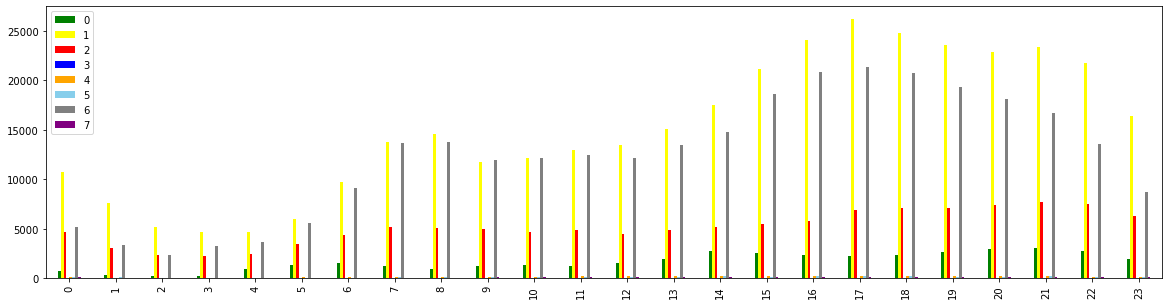

In [73]:
df_pivot.toPandas().plot(kind = 'bar', figsize=(20,5), color = ['green', 'yellow', 'red', 'blue', 'orange', 'skyblue', 'gray', 'purple'])

In [27]:
map_ny

In [41]:
df_agg = df_pivot.groupBy('cluster').count()
# df_agg = sqlContext.sql("SELECT cluster, count(cluster) AS cnt FROM temp GROUP BY cluster ORDER BY cluster")
df_agg.show()

+-------+------+
|cluster| count|
+-------+------+
|      0| 39906|
|      7|  1888|
|      6|294493|
|      5|  2616|
|      1|363950|
|      3|   478|
|      2|122761|
|      4|  3183|
+-------+------+



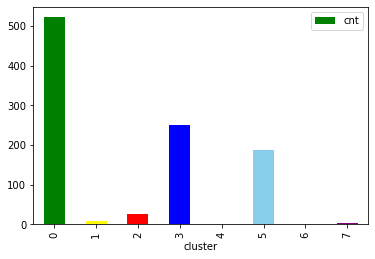

In [131]:
df_agg.toPandas().plot(kind = 'bar', x = 'cluster', y = 'cnt', color = ['green', 'yellow', 'red', 'blue', 'orange', 'skyblue', 'gray', 'purple'])

In [27]:
map_ny